### ORIGINAL FILE PURPOSE: TESTING SCRAPED PUBLIC REPOSITORY AE's
#### Discoveries: many scraped autoencoders, simply dont work/are outdated.
#### Going down a difficulty level to train on 2d images (middle slices) is a very good strategy.. (execution speed++, learning speed++)

In [1]:
# IMPORT EVERYTHING****!!!
from Architectures.AE_ADJ import AE # for some fucking reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load,load_middle_slices
from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE
from Filters.filters import edge_detect, preprocess_images

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input, AveragePooling2D

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from keras.saving import register_keras_serializable

from tensorflow.keras import layers, Model, models, Input, activations, regularizers
from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import math
import nibabel as nib
import json

In [ ]:

# spatially normalized brains were put in this path "\Data\Pre-processed"
take = 350 # max
H_train2D, H_test2D     = load_middle_slices(dataset_name="Pre-processed", axis="sagittal", train_test_split=0.8, take=take)
AD_train2D, AD_test2D   = load_middle_slices(dataset_name="Pre-processed-AD", axis="sagittal", train_test_split=0.8, take=take)
MCI_train2D, MCI_test2D = load_middle_slices(dataset_name="Pre-processed-MCI", axis="sagittal", train_test_split=0.8, take=take)

H_train3D, H_test3D     = load(dataset_name="Pre-processed", train_test_split=0.8, take=take)
AD_train3D, AD_test3D   = load(dataset_name="Pre-processed-AD", train_test_split=0.8, take=take)
MCI_train3D, MCI_test3D = load(dataset_name="Pre-processed-MCI", train_test_split=0.8, take=take)

H_2D = np.concatenate([H_train2D, H_test2D], axis=0)
AD_2D = np.concatenate([AD_train2D, AD_test2D], axis=0)
MCI_2D = np.concatenate([MCI_train2D, MCI_test2D], axis=0)

H_3D = np.concatenate([H_train3D, H_test3D], axis=0)
AD_3D = np.concatenate([AD_train3D, AD_test3D], axis=0)
MCI_3D = np.concatenate([MCI_train3D, MCI_test3D], axis=0)

Loading images:   0%|          | 0/338 [00:00<?, ?it/s]

Loading Pre-processed-MCI: 100%|██████████| 46/46 [00:12<00:00,  3.57it/s]


In [ ]:
# QUICKLY LOAD ALL DATA FROM npy files instead of loading data differently.
groups = {"CN":[],"MCI":[],"AD":[]}
for group in tqdm(groups, "Testing open times"):
    groups[group] = np.load(open(f"Data/D2-{group}-A.npy","br"))

train_test_split = 0.8
split_index = int(len(groups["CN"]) * train_test_split)
H_train2D, H_test2D = groups["CN"][:split_index], groups["CN"][split_index:]
AD_train2D, AD_test2D = groups["AD"][:split_index], groups["AD"][split_index:]
MCI_train2D, MCI_test2D = groups["MCI"][:split_index], groups["MCI"][split_index:]
H_2D = groups["CN"]
AD_2D = groups["AD"]
MCI_2D = groups["MCI"]

In [ ]:
k = 2
abs_ = True
a = 0.1
H_train2D_E, H_test2D_E = edge_detect(H_train2D, k=k, abs_=abs_, alpha=a), edge_detect(H_test2D, k=k, abs_=abs_, alpha=a)
AD_train2D_E, AD_test2D_E = edge_detect(AD_train2D, k=k, abs_=abs_, alpha=a), edge_detect(AD_test2D, k=k, abs_=abs_, alpha=a)
MCI_train2D_E, MCI_test2D_E = edge_detect(MCI_train2D, k=k, abs_=abs_, alpha=a), edge_detect(MCI_test2D, k=k, abs_=abs_, alpha=a)

# preprocess_images(H_train2D, processes=["SobelX"])

H_2D_E = np.concatenate([H_train2D_E, H_test2D_E], axis=0)
AD_2D_E = np.concatenate([AD_train2D_E, AD_test2D_E], axis=0)
MCI_2D_E = np.concatenate([MCI_train2D_E, MCI_test2D_E], axis=0)


In [ ]:
processes = ["Laplacian"]

H_train2D_E, H_test2D_E = preprocess_images(H_train2D, processes), preprocess_images(H_test2D, processes)
AD_train2D_E, AD_test2D_E = preprocess_images(AD_train2D, processes), preprocess_images(AD_test2D, processes)
MCI_train2D_E, MCI_test2D_E = preprocess_images(MCI_train2D, processes), preprocess_images(MCI_test2D, processes)

H_2D_E = np.concatenate([H_train2D_E, H_test2D_E], axis=0)
AD_2D_E = np.concatenate([AD_train2D_E, AD_test2D_E], axis=0)
MCI_2D_E = np.concatenate([MCI_train2D_E, MCI_test2D_E], axis=0)

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(H_train2D_E[0])
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(H_train2D[0])

In [ ]:
"""
custom_simple1 = AE(name="AE (3h, 32-128f, 16L, Batchnorm, SSIM_loss)", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (5,5), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32,  (5,5), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1,   (3,3), {'padding': 'same'}),
    ],
    VAE_model=True,
    loss=SSIM_loss
)

custom_simple2 = AE(name="AE (3h, 32-128f, 128L, Batchnorm, lky-rlu, transpose, SSIM_loss)", input_shape=H_train2D.shape, latent_dim=128,
       encoder_layers=[
        (layers.Conv2D, 16, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
        (layers.Conv2D, 32, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
        (layers.Conv2D, 64, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
    ],
    decoder_layers=[
        (layers.Conv2DTranspose, 64, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        (layers.Conv2DTranspose, 32, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        (layers.Conv2DTranspose, 16, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
       (layers.Conv2D, 1,  (3, 3), {'padding': 'same'}),
    ], VAE_model=False, loss=SSIM_loss)


custom_simple3 = AE(name="AE (3h, 64-256f, 32L, Batchnorm, lky-rlu, SSIM_loss)",input_shape=H_train2D.shape,latent_dim=32,
    encoder_layers=[
        (layers.Conv2D, 64, (7,7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (5,5), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(), layers.Dropout(0.2),
        (layers.Conv2D, 256, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(), layers.Dropout(0.3),
    ],
    decoder_layers=[
        (layers.Conv2D, 256, (3,3), {'padding': 'same', 'activation': 'relu'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 128, (5,5), {'padding': 'same', 'activation': 'relu'}), (layers.UpSampling2D, (2,2)), layers.Dropout(0.2),
        (layers.Conv2D, 64, (7,7), {'padding': 'same', 'activation': 'relu'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (1,1), {'padding': 'same'}),
    ],
    VAE_model=True, loss=SSIM_loss, learning_rate=0.0005
)

custom_simple4 = AE(name="AE (4h, 32-128f, 128L, relu, transpose, MSE_loss)",
    input_shape=H_train2D.shape,
    latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 64, (5, 5), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU()
    ],
    decoder_layers=[
        (layers.Conv2DTranspose, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 64, (5, 5), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 32, (3, 3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ], VAE_model=False, loss=MSE_loss, learning_rate=0.001)

A2 = AE(name="A2",
    input_shape=H_train2D.shape,
    latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 64, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU()
    ],
    decoder_layers=[
        (layers.Conv2DTranspose, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 128, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 64, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2DTranspose, 32, (7, 7), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), #layers.BatchNormalization(), #layers.LeakyReLU(),
        (layers.Conv2D, 1,  (7, 7), {'activation': 'sigmoid','padding': 'same',}),
    ], VAE_model=False, loss=MSE_loss, learning_rate=0.001)

custom_simplest_model = AE(name="custom_simplest_model", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 4, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 4, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=False, loss=MSE_loss)

public_repo = AE(name="public_repo", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=MSE_loss,learning_rate=0.001)

public_repo_vae = AE(name="public_repo_vae", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), 
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), 
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), 
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ],
    VAE_model=True, loss=MSE_loss,learning_rate=0.001)

alcoholism = AE(name="public_clcoholism_paper", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 40, (5, 5), {'activation': 'relu', 'strides': (3, 3), 'padding': 'valid'}), layers.BatchNormalization(),
        (layers.Conv2D, 80, (3, 3), {'activation': 'relu', 'strides': (5, 5), 'padding': 'valid'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}),
        (layers.Conv2D, 120, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}),
        (layers.Conv2D, 120, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (3, 3), 'strides': (1, 1), 'padding': 'same'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 120, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 120, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 80, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 80, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 40, (5, 5), {'padding': 'same'}), 
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001
)

frontiers = AE(name="public_frontiers_paper", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}), (layers.MaxPooling2D, {'pool_size': (2, 2), 'strides': (2, 2), 'padding': 'same'}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}), 
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'strides': (2, 2), 'padding': 'same'}), 
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'strides': (1, 1), 'padding': 'same'}), 
    ],
    decoder_layers=[
        (layers.Conv2DTranspose, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv2DTranspose, 32, (3, 3), {'activation': 'relu', 'padding': 'same', 'strides': 2}),
        (layers.Conv2DTranspose, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), 
        (layers.Conv2DTranspose, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2DTranspose, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001
)

unsupervised_anomaly = AE(name="public_unsupervised_anomaly", input_shape=H_train2D.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv2D, 64, (5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv2D, 128, (5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv2D, 16, (1, 1), {'activation': 'relu', 'strides': 1, 'padding': 'same'}), 
    ],
    decoder_layers=[
        (layers.Conv2D, 16, (1, 1), {'activation': 'relu', 'strides': 1, 'padding': 'same'}), 
        (layers.Conv2D, 128, (5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 64, (5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (1, 1), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001
)
"""

"""
unsupervised_anomaly_3d = AE(name="public_unsupervised_anomaly_3d", input_shape=H_train3D.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 32, (5, 5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv3D, 64, (5, 5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv3D, 128, (5, 5, 5), {'activation': 'relu', 'strides': 2, 'padding': 'same'}), 
        (layers.Conv3D, 16, (1, 1, 1), {'activation': 'relu', 'strides': 1, 'padding': 'same'}), 
    ],
    decoder_layers=[
        (layers.Conv3D, 16, (1, 1, 1), {'activation': 'relu', 'strides': 1, 'padding': 'same'}), 
        (layers.Conv3D, 128, (5, 5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 64, (5, 5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 32, (5, 5, 5), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 1, (1, 1, 1), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001
)
"""

public_repo_3d = AE(name="public_repo_autoencoder_3d", input_shape=H_train3D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3,3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 1,  (3, 3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=MSE_loss,learning_rate=0.001)

frontiers_3d = AE(name="public_frontiers_paper_3d", input_shape=H_train3D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'strides': (1, 1, 1), 'padding': 'same'}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'strides': (1, 1, 1), 'padding': 'same'}), (layers.MaxPooling3D, {'pool_size': (2, 2, 2), 'strides': (2, 2, 2), 'padding': 'same'}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'strides': (1, 1, 1), 'padding': 'same'}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'strides': (2, 2, 2), 'padding': 'same'}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'relu', 'strides': (1, 1, 1), 'padding': 'same'}),
    ],
    decoder_layers=[
        (layers.Conv3DTranspose, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv3DTranspose, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same', 'strides': (2, 2, 2)}),
        (layers.Conv3DTranspose, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}),
        (layers.Conv3DTranspose, 32, (3, 3, 3), {'activation': 'relu', 'padding': 'same'}), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3DTranspose, 1, (3, 3, 3), {'activation': 'sigmoid', 'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001
)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 20, 24, 20, 128)
Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 20, 24, 20, 32)


In [47]:
public_repo_l8 = AE(name="public_repo_l8", input_shape=H_train2D.shape, latent_dim=8,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=MSE_loss,learning_rate=0.001)


public_repo_l32 = AE(name="public_repo_l32", input_shape=H_train2D.shape, latent_dim=32,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=MSE_loss,learning_rate=0.001)


public_repo_l16_3pool = AE(name="public_repo_l16_3pool", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (AveragePooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (AveragePooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (AveragePooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss, learning_rate=0.001)

public_repo_l16_3Pool_short = AE(name="public_repo_l16_3Pool_short", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss,learning_rate=0.001)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 10, 12, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 10, 12, 64)


In [66]:
public_repo_ssim = AE(name="public_repo_ssim", input_shape=H_train2D.shape, latent_dim=32,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=SSIM_loss,learning_rate=0.001)

public_repo_nmse = AE(name="public_repo_nmse", input_shape=H_train2D.shape, latent_dim=32,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=SSIM_loss,learning_rate=0.001)

public_repo_nrmse = AE(name="public_repo_nrmse", input_shape=H_train2D.shape, latent_dim=32,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1,  (3, 3), {'activation': 'sigmoid','padding': 'same',}),
    ],
    VAE_model=False, loss=SSIM_loss,learning_rate=0.001)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [ ]:
custom_simple1 = AE(name="AE (3h, 32-128f, 16L, Batchnorm, SSIM_loss)", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (5,5), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32,  (5,5), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1,   (3,3), {'padding': 'same'}),
    ],
    VAE_model=True,
    loss=MSE_loss
)


In [103]:

models_list = [
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\custom_simplest_model\epoch_500\custom_simplest_model_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_clcoholism_paper\epoch_500\public_clcoholism_paper_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_frontiers_paper\epoch_250\public_frontiers_paper_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo\epoch_500\public_repo_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_unsupervised_anomaly\epoch_500\public_unsupervised_anomaly_autoencoder.keras")
]

models_list2 = [
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_frontiers_paper_3d\epoch_20\public_frontiers_paper_3d_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo_autoencoder_3d\epoch_20\public_repo_autoencoder_3d_autoencoder.keras"),
]

Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.


In [4]:
models_list = [public_repo_3d, frontiers_3d]

In [5]:
#models_list = [public_repo_3d, frontiers_3d] #[public_repo_3d, frontiers_3d, unsupervised_anomaly_3d]

# models_list = [public_repo_vae]
for m in models_list:
    m.train(H_train3D, H_test3D, epochs=50, batch_size=4, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models", 
    save_interval=10)

Training public_repo_autoencoder_3d on the CPU<class 'keras.src.models.functional.Functional'> (270, 80, 96, 80)
68/68 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - loss: 0.0670 - val_loss: 0.7628
68/68 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - loss: 0.0098 - val_loss: 0.4545
68/68 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 0.0069 - val_loss: 0.0429
68/68 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 0.0075 - val_loss: 0.0359
68/68 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - loss: 0.0062 - val_loss: 0.0281
68/68 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - loss: 0.0053 - val_loss: 0.0132
68/68 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 0.0049 - val_loss: 0.0081
68/68 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - loss: 0.0052 - val_loss: 0.0055
68/68 ━━━━━━━━━━━━━━━━━━━━ 303s 4s/step - loss: 0.0049 - val_loss: 0.0059
68/68 ━━━━━━━━━━━━━━━━━━━━ 302s 4s/step - loss: 0.0053 - val_loss: 0.0047
public_repo_autoencoder_3d
Models saved to C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\AE_ADJ_models\public_repo_autoencoder_3d\epoch_10 as

In [71]:

models_list = [
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo\epoch_500\public_repo_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo_l8\epoch_500\public_repo_l8_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo_l16_3pool\epoch_500\public_repo_l16_3pool_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo_l16_3Pool_short\epoch_500\public_repo_l16_3Pool_short_autoencoder.keras"),
    AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo_l32\epoch_500\public_repo_l32_autoencoder.keras")
]

Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.
Models loaded and compiled successfully.


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
ok (80, 96) (80, 96)
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000023C5D7F8540> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 786ms/step
ok (80, 96) (80, 96)


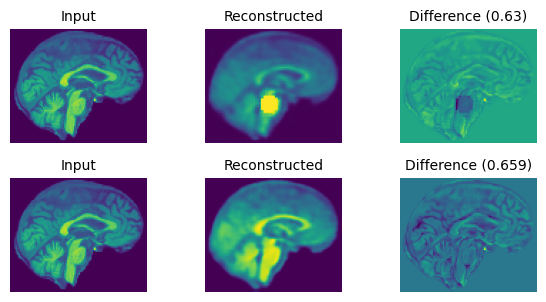

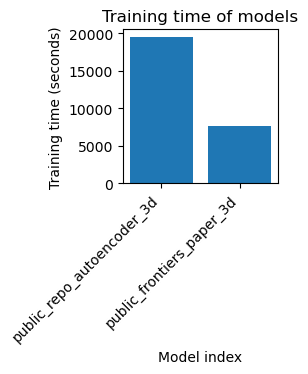

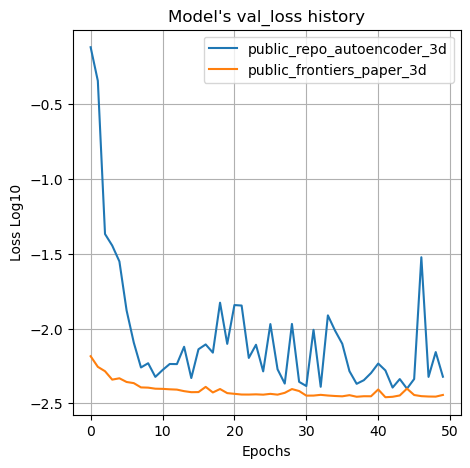

In [7]:
if 'models_list' in locals(): # if the variable exists
    
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=H_test3D, loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(2,2))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))

13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 59s 5s/step


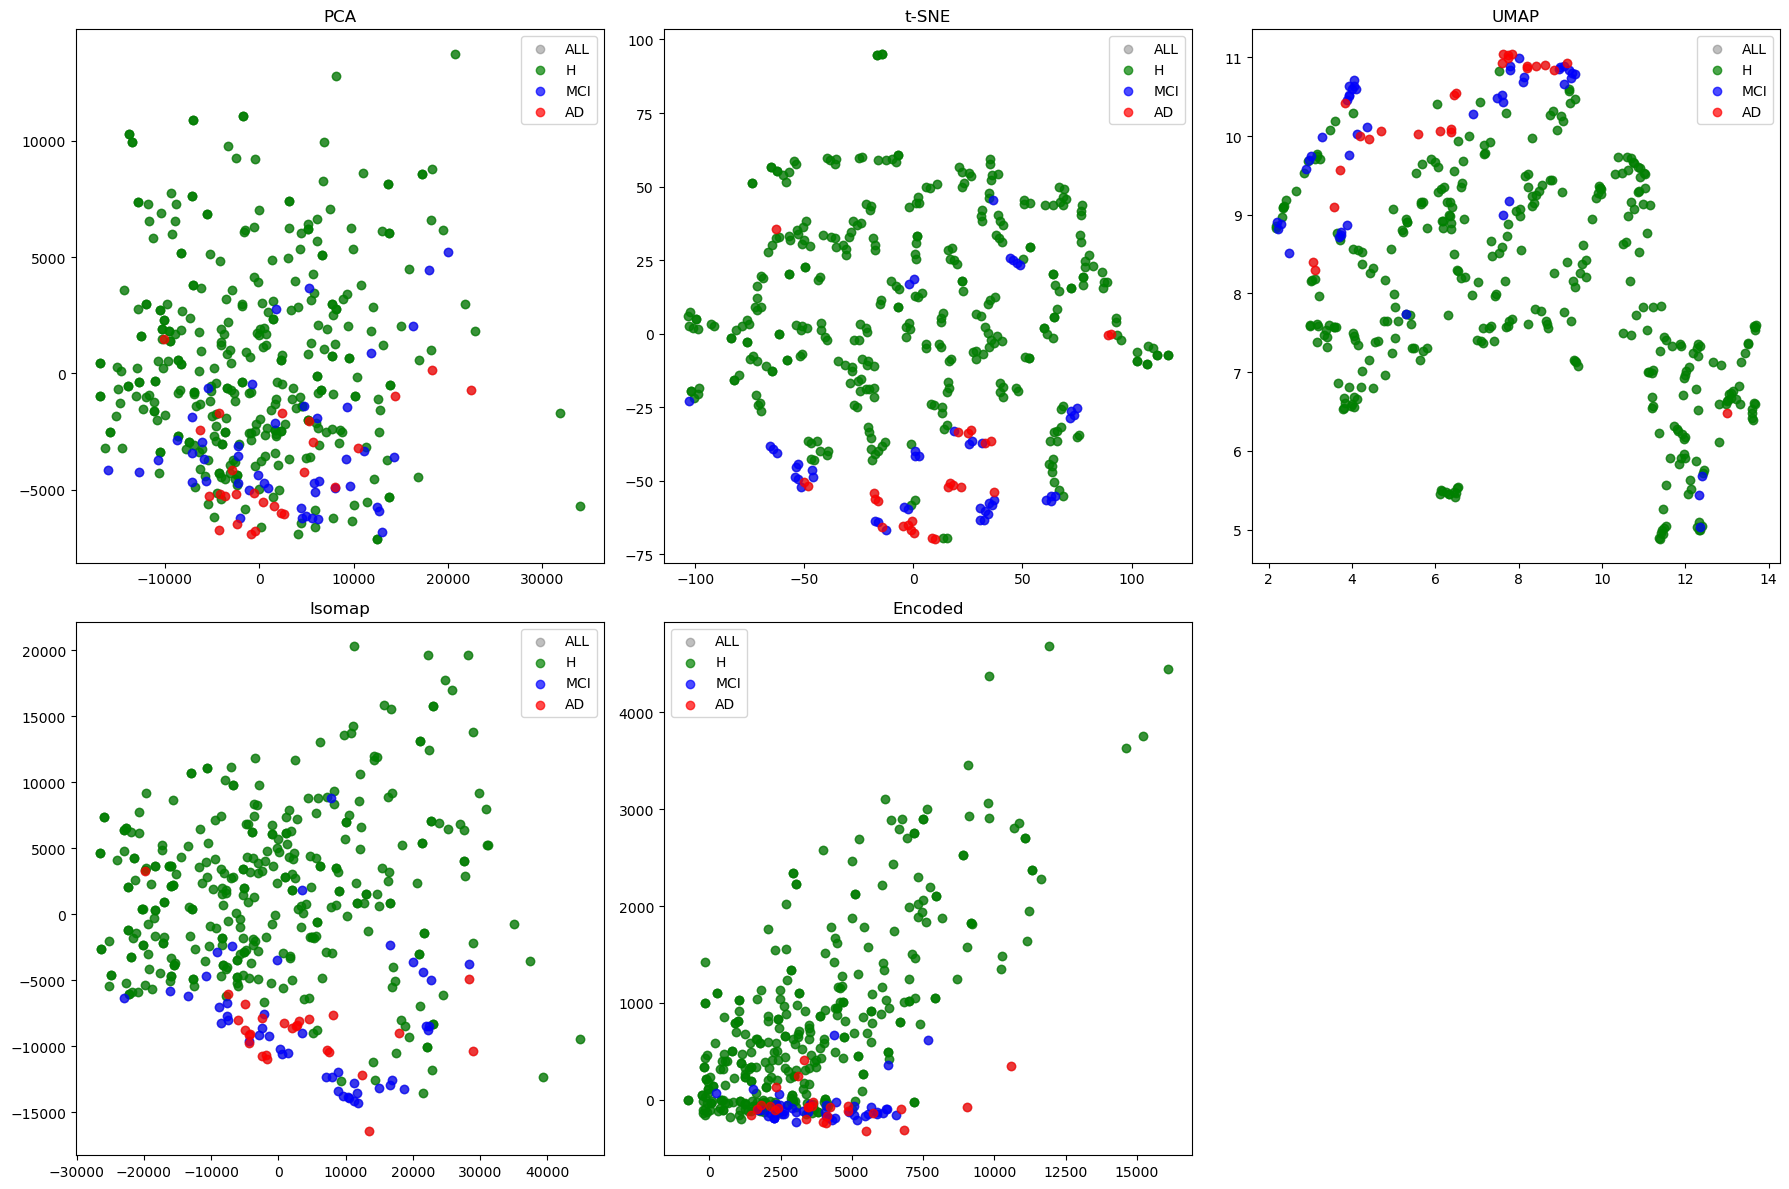

13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


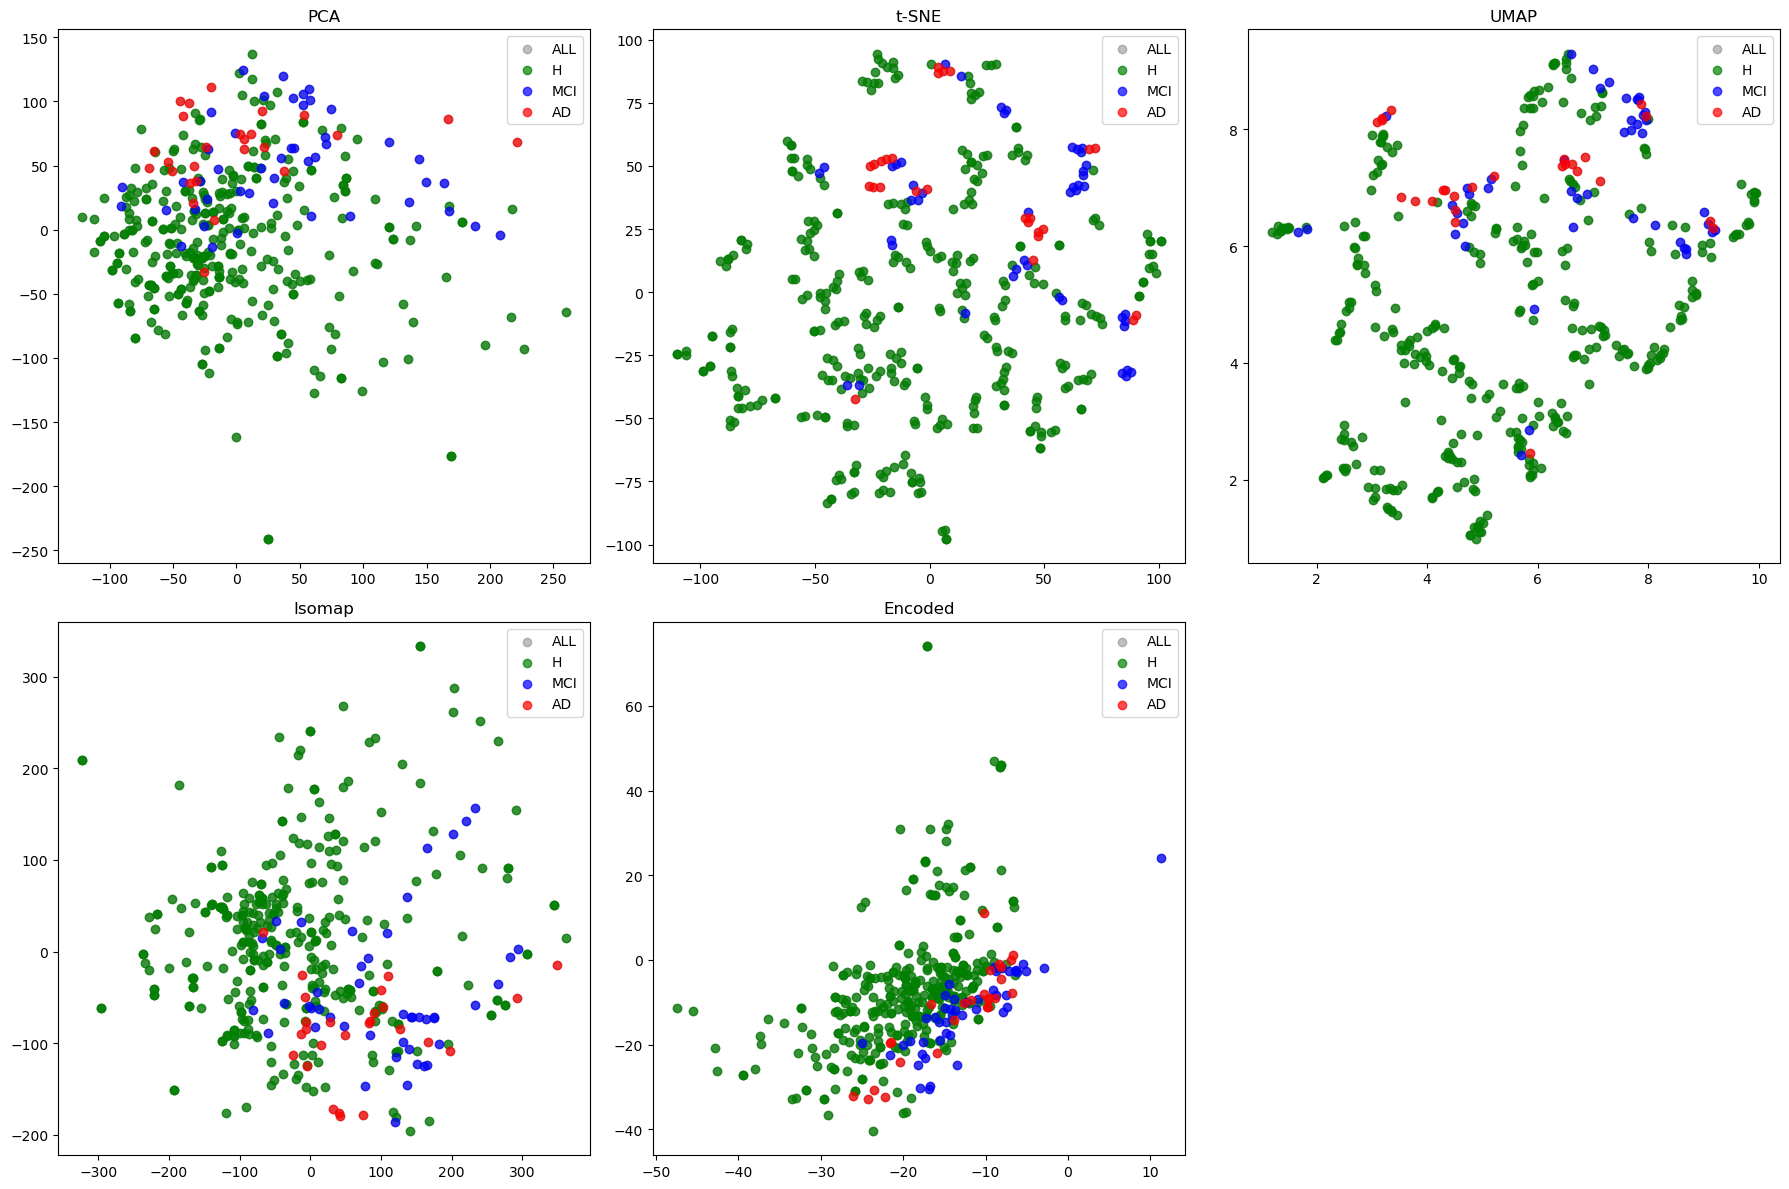

In [8]:
# models_list = [
#     AE.open(r"C:\Users\kiran\Documents\_UiS\sem6\bach\DementiaMRI\AE_ADJ_models\public_repo\epoch_300\public_repo_autoencoder.keras"),
# ]

TwoD = False

if TwoD:
    for m in models_list:
        plot_multiple_datasets(
        model=m,
        plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
        datasets=[H_2D, MCI_2D, AD_2D],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],#, "green", "blue"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"])
else:
    for m in models_list:
        plot_multiple_datasets(
        model=m,
        plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
        datasets=[H_3D, MCI_3D, AD_3D],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],#, "green", "blue"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"])

In [ ]:
E = AE(name="E", input_shape=train2d.shape, latent_dim=128,
    encoder_layers=[
        layers.Flatten(), 
        layers.Dense(512), layers.ReLU(),
        layers.Dense(256), layers.ReLU(),
        #layers.Dense(128), layers.ReLU(),  # Latent space
    ],
    decoder_layers=[
        layers.Dense(256), layers.ReLU(),
        layers.Dense(512), layers.ReLU(),
        layers.Dense(np.prod(train2d.shape[1:])), layers.ReLU(),
        layers.Reshape(train2d.shape[1:])  # Reshape to original dimensions
    ], 
    VAE_model=True, loss=SSIM_loss)


In [ ]:
images = []
titles = []
m = E
brain_scan_id = 0 

if m.VAE_model:
    latent = m.encode(H_test2D)[2]
else:            
    latent = m.encode(H_test2D)

import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=E.name, color="blue", alpha=0.3, density=True, bins=50) # Fill
#plt.hist(latent[1].flatten(), label=models_list[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=models_list[0].name, color="blue", alpha=0.3, density=True, bins=50) # Fill
plt.hist(latent[1].flatten(), label=models_list[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()